## Neural network predicting 5 points at once based on velocities

In [12]:
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

## Data preparation

In [13]:
from data_processing import read_edinburgh_data 
data, agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:03<00:00, 36.85it/s]


Warning! too big dt in [Edinburgh]
finish


In [34]:
train_agent_ids = np.load('Edinburgh_train_agent_ids.npy')
test_agent_ids = np.load('Edinburgh_test_agent_ids.npy')

### Helper functions

In [35]:
def create_dataset(data, agent_ids):
    data_X, data_Y_vel_x, data_Y_vel_y = [], [], []
    for agent_id in agent_ids:
        # We only see 4 velocities, so train is 4 velocities long
        x = data[data['agent_id'] == agent_id].iloc[1:5][['vel_x', 'vel_y']]
        y_vel_x = data[data['agent_id'] == agent_id].iloc[5:10]['vel_x']
        y_vel_y = data[data['agent_id'] == agent_id].iloc[5:10]['vel_y']
        data_X.append(x)
        data_Y_vel_x.append(y_vel_x)
        data_Y_vel_y.append(y_vel_y)
    return np.array(data_X), np.array(data_Y_vel_x), np.array(data_Y_vel_y)
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

## Experiment

In [36]:
train = create_dataset(data, train_agent_ids)
test = create_dataset(data, test_agent_ids)

In [37]:
from keras.models import Model
from keras.layers import *
from keras import backend as K

# Note: RMSE seems to yield a worse loss than mean_squared_error
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def RMSE_with_discount(y_true, y_pred):
    difference = y_true - y_pred
    difference = difference * [1, 0.95, 0.90, 0.85, 0.80]
    return K.sqrt(K.mean(K.square(difference))) 
    

#inp = Input((5,2))
inp = Input((4,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

'''
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
'''
out1 = Dense(5, activation='linear')(x)    
out2 = Dense(5, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = RMSE)

In [38]:
y_vel_x, y_vel_y = train[1], train[2] # separate the y data into x and y position columns
model.fit(train[0], [y_vel_x, y_vel_y], epochs=400, batch_size=32, verbose=2)
model.save('models/Edinburgh_NN_5_point_pred_velocity')

Epoch 1/400


2022-01-14 12:04:26.548570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 - 1s - loss: 0.9391 - dense_22_loss: 0.4174 - dense_23_loss: 0.5217 - 556ms/epoch - 11ms/step
Epoch 2/400
50/50 - 0s - loss: 0.7939 - dense_22_loss: 0.3637 - dense_23_loss: 0.4302 - 272ms/epoch - 5ms/step
Epoch 3/400
50/50 - 0s - loss: 0.6861 - dense_22_loss: 0.3230 - dense_23_loss: 0.3631 - 269ms/epoch - 5ms/step
Epoch 4/400
50/50 - 0s - loss: 0.6323 - dense_22_loss: 0.2979 - dense_23_loss: 0.3344 - 273ms/epoch - 5ms/step
Epoch 5/400
50/50 - 0s - loss: 0.6116 - dense_22_loss: 0.2896 - dense_23_loss: 0.3220 - 271ms/epoch - 5ms/step
Epoch 6/400
50/50 - 0s - loss: 0.5992 - dense_22_loss: 0.2855 - dense_23_loss: 0.3137 - 306ms/epoch - 6ms/step
Epoch 7/400
50/50 - 0s - loss: 0.5928 - dense_22_loss: 0.2831 - dense_23_loss: 0.3097 - 277ms/epoch - 6ms/step
Epoch 8/400
50/50 - 0s - loss: 0.5794 - dense_22_loss: 0.2736 - dense_23_loss: 0.3058 - 269ms/epoch - 5ms/step
Epoch 9/400
50/50 - 0s - loss: 0.5807 - dense_22_loss: 0.2758 - dense_23_loss: 0.3048 - 274ms/epoch - 5ms/step
Epoch 10/400

In [40]:
trainScore = model.evaluate(train[0], [train[1], train[2]], verbose=0)
print('Train Score: %.2f' % (trainScore[0]))

testScore = model.evaluate(test[0], [test[1], test[2]], verbose=0)
print('Test Score: %.2f' % (testScore[0]))

Train Score: 0.42
Test Score: 0.64


## Making predictions on test data

2022-01-14 11:55:01.735893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


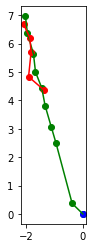

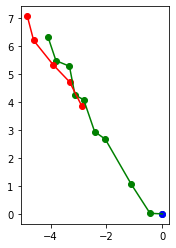

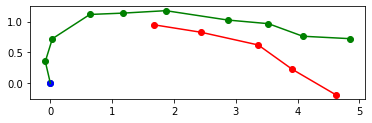

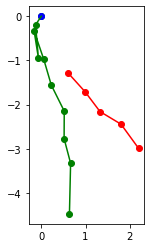

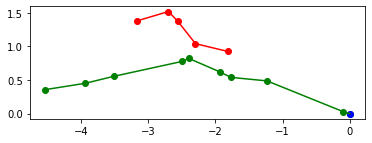

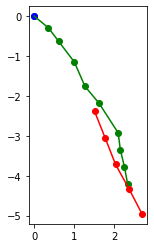

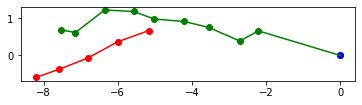

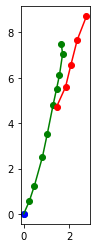

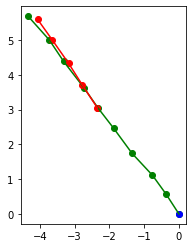

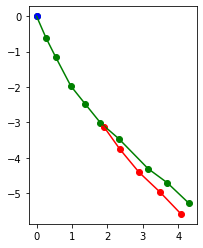

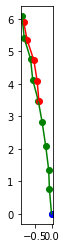

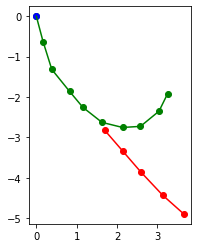

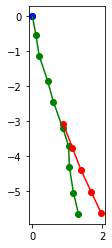

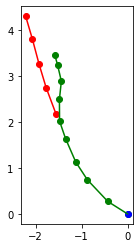

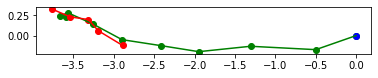

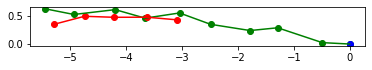

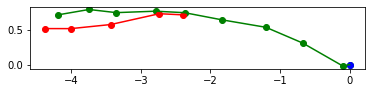

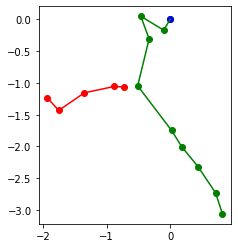

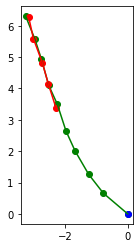

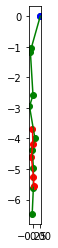

Average FDE:  1.0883248996301342


In [22]:
all_FDE = []
plotting = True
no_of_plotted_trajectories = 20

for idx, agent_id in enumerate(test_agent_ids):

    seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
    seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
    
    seen_vel_x = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_x'])
    seen_vel_y = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_y'])
    
    unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
    unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

    pred_vel_x, pred_vel_y = model.predict(np.array([np.column_stack((seen_vel_x, seen_vel_y))]))
    pred_vel_x = pred_vel_x[0] # destructure the prediction array as it is [[x1, x2, x3...]]
    pred_vel_y = pred_vel_y[0]
    
    pred_coord_x = [seen_x[-1] + pred_vel_x[0]]
    pred_coord_y = [seen_y[-1] + pred_vel_y[0]]
    
    for i in range(1, 5):
        pred_coord_x.append(pred_coord_x[-1] + pred_vel_x[i])
        pred_coord_y.append(pred_coord_y[-1] + pred_vel_y[i])

    FDE = np.sqrt((pred_coord_x[-1] - unseen_x[-1])**2 + (pred_coord_y[-1] - unseen_y[-1])**2)
    all_FDE.append(FDE)
    # plot data
    if plotting and idx < no_of_plotted_trajectories:
        plt.axes().set_aspect('equal')

        plt.plot(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')
        plt.scatter(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')

        plt.plot(pred_coord_x, pred_coord_y, color='r')
        plt.scatter(pred_coord_x, pred_coord_y, color='r')

        plt.scatter(seen_x[0], seen_y[0], color='b')

        plt.show()

print("Average FDE: ", np.mean(all_FDE))

In [ ]:
print(len(test_agent_ids))
print(len(train_agent_ids))

## Testing different hyperparameters

In [ ]:
# NN architecture
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

inp = Input((5,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

out1 = Dense(5, activation='linear')(x)    
out2 = Dense(5, activation='linear')(x)

In [ ]:
tf.get_logger().setLevel('ERROR')

learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [1, 4, 8, 16, 32]
loss_functions = ['mean_squared_error', root_mean_squared_error]

all_train_RMSE = []
all_test_RMSE = []

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for loss_function in loss_functions:
            model = Model(inputs=inp, outputs=[out1,out2])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = loss_function)

            model.fit(train[0], [train[1], train[2]], epochs=200, batch_size=32, verbose=0)
            
            trainScore = model.evaluate(train[0], [train[1], train[2]], verbose=0)
            testScore = model.evaluate(test[0], [test[1], test[2]], verbose=0)
            
            if loss_function == 'mean_squared_error':
                all_train_RMSE.append(np.sqrt(trainScore[0]))
                all_test_RMSE.append(np.sqrt(testScore[0]))
                #Wprint("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function))
                #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], np.sqrt(trainScore[0])))
                #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], np.sqrt(testScore[0])))
            else:
                all_train_RMSE.append(trainScore[0])
                all_test_RMSE.append(testScore[0])
                #print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function.__name__))
                #print('Train Score: %.2f RMSE' % (trainScore[0]))
                #print('Test Score: %.2f RMSE' % (testScore[0]))


In [ ]:
best_learning_rate = None
best_batch_size = None
best_loss_function = None
best_test_rmse = min(all_test_RMSE)
best_test_rmse_idx = all_test_RMSE.index(best_test_rmse)

rmse_idx = 0
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for loss_function in loss_functions:
            
            if rmse_idx == best_test_rmse_idx:
                best_learning_rate = learning_rate
                best_batch_size = batch_size
                if loss_function == 'mean_squared_error':
                    best_loss_function = loss_function
                else:
                    best_loss_function = loss_function.__name__
            
            if loss_function == 'mean_squared_error':
                print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function))
            else:
                print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function.__name__))
            print('Train Score: %.2f RMSE' % (all_train_RMSE[rmse_idx]))
            print('Test Score: %.2f RMSE' % (all_test_RMSE[rmse_idx]))
            print()
            rmse_idx += 1

In [ ]:
print("Best test RMSE: ", best_test_rmse)
print("Best learning rate: ", best_learning_rate)
print("Best batch size: ", best_batch_size)
print("Best loss function: ", best_loss_function)